In [3]:
# import packages
import os 
import json
import lzma

import pandas as pd
import numpy as np

# list of txt files


# data download

extract files

In [4]:
# text data extraction
data_dir = "data/piero_data_txt"

# get all the names of the text files
tagged_posts_names = [obs for obs in os.listdir(data_dir) if ".txt" in obs]

# get all the paths of the text files
tagged_posts_paths = [os.path.join(data_dir, obs) for obs in tagged_posts_names]

### Json

In [5]:
## json extraction
#data_dir = "data/File_json"

# get all the names of the text files
#tagged_posts_names = [obs for obs in os.listdir(data_dir) if ".json" in obs]

# # get all the paths of the text files
# tagged_posts_paths = [os.path.join(data_dir, obs) for obs in tagged_posts_names]

# with open("data/File_json/KPMG.json") as file:
#     existing_data = json.loads(file.read())

#tagged_posts = spark.read.json(tagged_posts_paths)

### Text

In [6]:
# Selection for testing pre-selected pdf (olivier Be)----------- to be removed for final
# comparer 168833   200-2021-011085 (parent)  and 167280  200-2021-013474  (child)     diff in new one in chp 2 article 3

# text data extraction
data_dir = "data/piero_data_txt"

# get all the names of the text files
tagged_posts_names = ['200-2021-011085.pdf_fr.txt','200-2021-013474.pdf_fr.txt','200-2019-010020.pdf_fr.txt']
#['200-2019-010016.pdf_fr.txt','200-2019-010020.pdf_fr.txt','200-2020-000391.pdf_fr.txt','200-2020-009334.pdf_fr.txt','200-2021-013466.pdf_fr.txt']

# get all the paths of the text files
tagged_posts_paths = [os.path.join(data_dir, obs) for obs in tagged_posts_names]

print(tagged_posts_paths)

['data/piero_data_txt/200-2021-011085.pdf_fr.txt', 'data/piero_data_txt/200-2021-013474.pdf_fr.txt', 'data/piero_data_txt/200-2019-010020.pdf_fr.txt']


### data frame creation

In [7]:
# Read and update name column

tagged_posts = pd.concat((pd.read_table(f) for f in tagged_posts_paths), ignore_index=False).T.reset_index()
tagged_posts['pdf_name'] = tagged_posts_names
tagged_posts = tagged_posts.rename(columns={"index": "value"})

# Data preprocessing

### Define functions and parametring of functions

In [43]:
import nltk
nltk.download('stopwords')

from string import punctuation
from nltk.corpus import stopwords

# define what contain punctuation and stpwords
#NUMBER is a fix to remove number in string format
#NUMBERS =[str(x) for x in (list(range(0,100)))]
PUNCTUATION = [char for char in punctuation if char not in ["/","-", "@","°","§","_"]]
STOPWORDS = stopwords.words("french")#+ NUMBERS

# define function to remove punctuation
def remove_punct(text):
    # remove punctuation
    text = "".join([char for char in text if char not in PUNCTUATION])
    return(text)

# define function to remove stopwords
def remove_stops(text_tokenized):
    # remove stopwords
    text_tokenized = [word for word in text_tokenized if word not in STOPWORDS]
    return(text_tokenized)

# define tokenization function
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

def text_tokenized(text):
    words = word_tokenize(text)
    return words

#define text stemmizationfunction
snow = SnowballStemmer('french')

def stemmization(text_tokenized_no_stops):
    stemmed_sentence = []
    # Word Tokenizer
    for word in text_tokenized_no_stops:
        # Apply Stemming
        stemmed_sentence.append(snow.stem(word))
    stemmed_text = " ".join(stemmed_sentence)
    return stemmed_text

# define text lementization (whith tokenization and changing tokenization method to tokenize base on space)
import spacy
from spacy.lang.fr.examples import sentences
from spacy.tokens import Doc

class WhitespaceTokenizer:
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        words = text.split(" ")
        spaces = [True] * len(words)
        # Avoid zero-length tokens
        for i, word in enumerate(words):
            if word == "":
                words[i] = " "
                spaces[i] = False
        # Remove the final trailing space
        if words[-1] == " ":
            words = words[0:-1]
            spaces = spaces[0:-1]
        else:
           spaces[-1] = False

        return Doc(self.vocab, words=words, spaces=spaces)
    
#text lemmatization
nlp = spacy.load('fr_core_news_md')
nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)
#nlp = spacy.blank("fr")

def lemmatized(text):
    lemmatized_sentence = []
    doc = nlp(text)
    for token in doc:
        # Apply Stemming
        lemmatized_sentence.append(token.lemma_)
    return lemmatized_sentence

# definition to join text
def join_sentences(text):
    for word in text:
        text_join = " ".join(text)
    return text_join



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/juliendesmedt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/juliendesmedt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/juliendesmedt/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/juliendesmedt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
tagged_posts

,value,pdf_name
0,Neerlegging-Dépôt: 22/09/2021 N°: 167280/CO/20...,200-2021-011085.pdf_fr.txt
1,Neerlegging-Dépôt: 24/11/2021 Regist. -Enregis...,200-2021-013474.pdf_fr.txt
2,Correction - Correction - DécisionService publ...,200-2019-010020.pdf_fr.txt


### Running data processing

In [10]:
# text preprocessing stemmed
tagged_posts['text_lower'] = tagged_posts['value'].map(str.lower)
tagged_posts['text_cleaned'] = tagged_posts['text_lower'].map(remove_punct)
tagged_posts['text_tokenized'] = tagged_posts['text_cleaned'].map(text_tokenized)
tagged_posts['text_tokenized_no_stops'] = tagged_posts['text_tokenized'].map(remove_stops)
tagged_posts['text_stemmed'] = tagged_posts['text_tokenized_no_stops'].map(stemmization)
tagged_posts = tagged_posts.drop(['text_lower','text_cleaned','text_tokenized','text_tokenized_no_stops'], axis=1)

# text preprocessing lemmatized
tagged_posts['text_lower'] = tagged_posts['value'].map(str.lower)
tagged_posts['text_cleaned'] = tagged_posts['text_lower'].map(remove_punct)
tagged_posts['text_lemmatized'] = tagged_posts['text_cleaned'].map(lemmatized)
tagged_posts['text_tokenized_no_stops'] = tagged_posts['text_lemmatized'].map(remove_stops)
tagged_posts['text_final_lemmatized'] = tagged_posts['text_tokenized_no_stops'].map(join_sentences)
tagged_posts = tagged_posts.drop(['text_lower','text_cleaned','text_lemmatized','text_tokenized_no_stops'], axis=1)


In [42]:
def text_lematization(text):
    # text preprocessing lemmatized
    text_lower = str.lower(text)
    text_cleaned = remove_punct(text_lower)
    tokenized = text_tokenized(text_cleaned)
    text_lemmatized = lemmatized(tokenized)
    text_tokenized_no_stops = remove_stops(text_lemmatized)
    text_final_lemmatized = join_sentences(text_tokenized_no_stops)
    return (text_final_lemmatized)

def text_lematization(text):
    # text preprocessing lemmatized
    text_lower = str.lower(text)
    text_cleaned = remove_punct(text_lower)
    text_lemmatized = lemmatized(text_cleaned)
    text_tokenized_no_stops = remove_stops(text_lemmatized)
    text_final_lemmatized = join_sentences(text_tokenized_no_stops)
    return (text_final_lemmatized)


In [36]:
text_lematization(tagged_posts['value'][0])

'neerlegging-dépôt 22/09/2021 numéro 167280/co/200 regist -enreqistr 23/09/2021 commission paritaire auxiliaire employé convention collectif travail 20 septembre 2021 conclure sein commission paritaire auxiliaire employé relatif crédit-temp chapitre ier champ dapplication article 1er présent convention collectif travail sappliqu employeur employé entreprise relever compétence com- mission paritaire auxiliaire employé entendre employé   employé mascu- lin féminin chapitre ii crédit-temp art 2 application larticle 2 § 3 con- vention collectif travail numéro 103 instaurer système crédit-temp diminution carrière demploi fin carrière possibilité dérogation suivant être fixer   employé nappartiennent per- sonnel dexécution employé exer- cent fonction nest exercer autre employer lentreprise lexercice droit crédit-temp requérir laccord lemployeurlautorisation refus lemployeur être communiquer travailleur plus tard dernier jour mois suivre celui où travailleur avoir for- mulé demande écrire lar

In [12]:
tagged_posts

,value,pdf_name,text_stemmed,text_final_lemmatized
0,Neerlegging-Dépôt: 22/09/2021 N°: 167280/CO/20...,200-2021-011085.pdf_fr.txt,neerlegging-dépôt 22/09/2021 n° 167280/co/200 ...,neerlegging-dépôt 22/09/2021 numéro 167280/co/...
1,Neerlegging-Dépôt: 24/11/2021 Regist. -Enregis...,200-2021-013474.pdf_fr.txt,neerlegging-dépôt 24/11/2021 regist -enregistr...,neerlegging-dépôt 24/11/2021 regist -enregistr...
2,Correction - Correction - DécisionService publ...,200-2019-010020.pdf_fr.txt,correct - correct - décisionservic public dire...,correction - correction - décisionservice publ...


In [13]:
tagged_posts['len_text'] = tagged_posts.apply(lambda row : len(row[0]), axis=1)
tagged_posts['len_stem'] = tagged_posts.apply(lambda row : len(row[2]), axis=1)
tagged_posts['len_lemma'] = tagged_posts.apply(lambda row : len(row[3]), axis=1)

In [14]:
tagged_posts['text_tokenized'] = tagged_posts['text_final_lemmatized'].map(text_tokenized)

In [15]:
tagged_posts.to_csv('data/text_process.csv')

# Text comparison

In [16]:
# text sementic comparison
from sentence_transformers import SentenceTransformer, util

parent = tagged_posts['text_final_lemmatized'][0]
child = tagged_posts['text_final_lemmatized'][1]

model = SentenceTransformer('all-mpnet-base-v2')

def text_sementic_comparison(parent,child):
    first = model.encode(parent)
    second = model.encode(child)

    cos_sim = util.pytorch_cos_sim(first, second)

    return (cos_sim, first)

text_comparison_score, first = text_sementic_comparison(parent, child)

In [17]:
# text sementic comparison
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-mpnet-base-v2')

def text_vectorization(text):
    vector = model.encoder(text)
    return vector


In [18]:
first

array([ 1.89105365e-02,  1.61328185e-02,  5.42548019e-03,  2.92100408e-03,
       -3.89184766e-02,  2.84431279e-02,  2.64710449e-02,  5.66476099e-02,
        1.78094227e-02,  1.39647862e-02,  5.42318150e-02,  1.61529612e-02,
        5.54988980e-02, -1.39445940e-03, -2.34490689e-02,  6.09396398e-02,
        3.04872878e-02,  4.95095067e-02, -4.62103225e-02, -1.93067419e-03,
       -1.02909962e-02,  7.46426061e-02, -8.51645600e-03,  6.45633265e-02,
       -3.86388414e-03, -5.41179487e-03,  5.11162244e-02,  1.73757412e-02,
        4.24975716e-03, -1.72143504e-02,  9.65128317e-02,  1.71389356e-02,
        2.51663011e-02, -1.60187669e-02,  2.59023068e-06, -2.60920580e-02,
       -2.86272522e-02, -4.69751237e-03, -2.26873923e-02,  1.01598985e-02,
       -5.13576046e-02, -4.99908440e-02, -2.27797050e-02,  2.35854113e-03,
       -4.70813736e-03,  3.69475558e-02,  2.20992751e-02, -3.06891873e-02,
        2.71864403e-02,  5.31695820e-02, -3.30492714e-03, -2.44832933e-02,
       -9.44903940e-02, -

# Comparison child parent

In [19]:
new_title_list = pd.DataFrame('new_title')
dic_comparison_score ={}

for new_title in new_title_list:
    old_title_list = pd.DataFrame('meta_data', columns=['title', 'date_depot'])
    old_title_list = old_title_list.sort_values(by=['date_depot'])

    for old_title in old_title_list['title']:
        if new_title = old_title & date_depot_new > date_depot_old):
            comparison_score = comparison old vs new
            if comparison_score > 70%:
                dic_comparison_score['new_id'] = new_title[id]
                dic_comparison_score['old_id'] = old_title[id]
                dic_comparison_score['score'] = comparison_score
                dic_comparison_score['status'] = 'possible_child'
                for chapitre_new in new_title['title'].chapitre:
                    for old_chapter in old_title_list['title'].chapitre:
                        if chapitre_new = old_chapter:
                            compare
                        elif:
                            if chapter_new_content = chapter_old_content

            else:
                dic_comparison_score['new_id'] = new_title[id]
                dic_comparison_score['old_id'] = old_title[id]
                dic_comparison_score['score'] = comparison_score
                dic_comparison_score['status'] = 'not_child'
        else (faire des boucles dans les référence et voir si références corresponde en comparaison et appliquer les même principe pour comparer les chapitre entre eux)

        quand un chapitre n'as pas de correspondance ou qu'un chappitre s'emble avoir changer si nouveau on résume le nouveau via GPT si update on compare avec l'acien chapitre.



SyntaxError: invalid syntax (1079012832.py, line 9)

In [20]:
with open("data/CLA_raw_DB.json", "r") as read_file:
    df_200 = json.load(read_file)

In [21]:
parent = df_200['200-2021-011085.pdf']['articles_content']
#child = df_200[]

In [44]:
import ast
with open('data/save.txt', 'r') as file:
    s = file.read()

result = ast.literal_eval(s)

key_list_child = result[0]["20201-2022-000778.pdf"]["articles_content"].keys()

key_list_parent = result[1]["20201-2020-008676.pdf"]["articles_content"].keys()

score_dict = {}

for pdf_2art in key_list_child:
    article_pdf2 = result[0]["20201-2022-000778.pdf"]["articles_content"][pdf_2art]
    article_pdf2 = text_lematization(article_pdf2)
    each_score = {}
    for pdf_1art in key_list_parent:
        article_pdf1 = result[1]["20201-2020-008676.pdf"]["articles_content"][pdf_1art]
        article_pdf1 = text_lematization(article_pdf1)
        first = model.encode(article_pdf2)
        second = model.encode(article_pdf1)
        cos_sim = util.pytorch_cos_sim(first, second)
        each_score[pdf_1art] = cos_sim
        #print(f'{pdf_2art} score against {pdf_1art}',cos_sim)
    score_dict[pdf_2art] = each_score

corresponding_article = {}

for article in score_dict:
    art_number = max(score_dict[article], key=score_dict[article].get)
    max_score = max(score_dict[article].values())
    corresponding_article[art_number] = max_score

text

In [45]:
corresponding_article

{'art_1': tensor([[0.9995]]),
 'art_2': tensor([[1.0000]]),
 'art_3': tensor([[0.9942]]),
 'art_4': tensor([[0.9972]]),
 'art_5': tensor([[1.]]),
 'art_6': tensor([[1.0000]]),
 'art_7': tensor([[1.0000]]),
 'art_8': tensor([[0.9668]]),
 'art_9': tensor([[0.9683]])}

# END of code

# word counter

In [ ]:
from collections import Counter
import operator

In [ ]:
# convert to pandas
nbr_words_pandas =  tagged_posts

In [ ]:
# initialize counter
counter = Counter()

# loop through text documents
for i in range(len(nbr_words_pandas)):
    # get text doc 
    text_doc = nbr_words_pandas["text_tokenized"].iloc[i]
    # remove single characters
    text_doc = [word for word in text_doc if len(word) > 1]
    # update counter
    counter.update(text_doc)

# sort counter
counter_dict = dict(counter)
counter_dict_sorted = list(sorted(counter_dict.items(), key=operator.itemgetter(1)))
words = [obs[0] for obs in counter_dict_sorted]
counts = [obs[1] for obs in counter_dict_sorted]

In [ ]:
print(words[:200])

['22/09/2021', '167280/co/200', '-enreqistr', '23/09/2021', 'septembre', 'ier', 'mascu-', 'lin', 'per-', 'sonnel', 'exer-', 'cent', 'lemployeurlautorisation', 'for-', 'mulé', 'syn-', 'dical', 'lar-', 'ticle', 'lel', '1el', '103chapitre', 'vail', 'nal', 'durée', '1erjuillet', 'duire', '2021de', 'natio-', 'pro-', '24/11/2021', '-enregistr', '13/12/2021', '168833/co/200', '18', 'novembre', 'ploye', 'concerner', 'art1er', 'credit', '-temp', 'cré-', 'dit-temps', 'person-', 'nel', 'commu-', 'niquer', 'syndi-', 'cale', 'di-', 'ligente', 'employésart3', 'modifier', '103ter', 'valoir', '15juillet2021', 'lective', '103§', 'accè-', 'der', 'au-', 'delà', 'so-', 'cial', '157', '7479', '2022', 'inclure', 'disposi-', 'pré-', 'sentir', 'art5', 'décisionservice', 'public', 'relation', 'té', 'dufédéral', 'concertation', 'général', 'greffe', 'erratum', '152855/co/200', '01107/2019', 'deux', 'langue', 'disparaître', 'texte', 'français', 'tiret', 'corriger', 'diminu-', 'por-commission', 'employes', '200', 

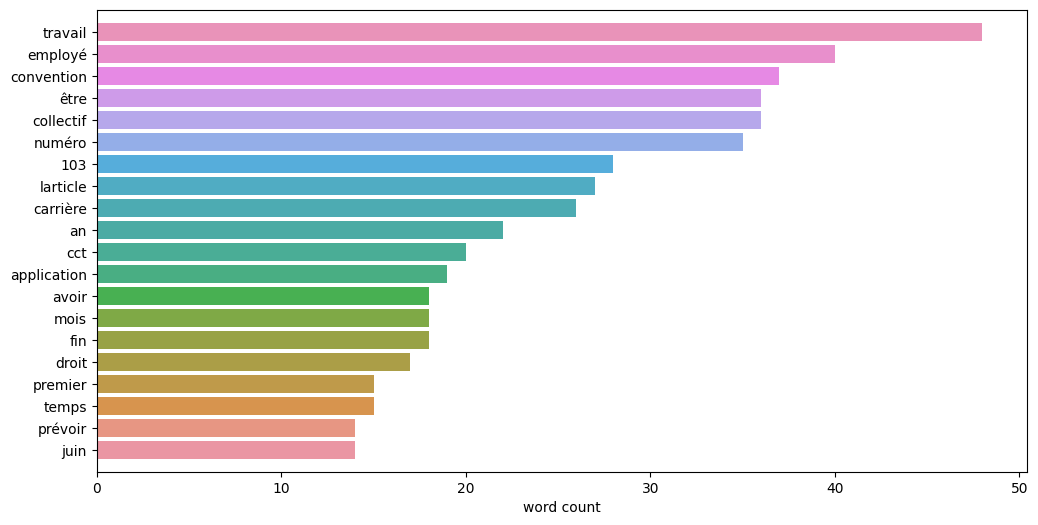

In [ ]:
# plot 
plt.figure(figsize=(12, 6))
sns.barplot(y=words[-20:], x=counts[-20:], orient="h")
plt.yticks(range(20), words[-20:])
plt.ylim([-1, 20])
plt.xlabel("word count")
plt.show()